# Predicting factor scores from individual questions

This might be entirely stupid but it seems to work. The aim is to find a few questions that predict factor scores accurately so we can use just these instead of the all the questions. 

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats.distributions import halfcauchy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
import joblib
import os
import matplotlib
import matplotlib.font_manager as font_manager
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#4f4f4f', '#B80044', '#0e79b2']

## Load the data

In [3]:
qns = pd.read_csv('qns.csv')
scores = pd.read_csv('scores.csv')

In [4]:
qns.head()

,Unnamed: 0,qnid,zung.1,zung.2,zung.3,zung.4,zung.5,zung.6,zung.7,zung.8,...,apathy.9,apathy.10,apathy.11,apathy.12,apathy.13,apathy.14,apathy.15,apathy.16,apathy.17,apathy.18
0,1,4048436,1,2,1,1,2,1,2,1,...,1,1,1,1,3,2,2,1,2,2
1,2,4784881,4,4,2,4,4,4,4,4,...,1,3,4,4,4,3,4,4,4,4
2,3,5606197,1,3,1,1,2,3,1,1,...,2,3,3,2,1,2,2,3,3,2
3,4,1247914,3,4,1,3,4,4,4,1,...,3,1,2,4,4,3,2,2,3,3
4,5,1614684,1,3,1,1,2,1,1,2,...,1,1,1,1,2,1,1,1,1,1


## Classifier

This is done using multi-target regression (i.e. predicting scores on the 3 factors based on the individual questions). Using lasso so we get some questions with weights set to zero.

In [5]:
clf = Lasso()

## Hyperparameter optimisation

Find the best alpha value using 5-fold CV

In [6]:
alpha_values = [0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

Loop over candidate alpha values and record $R^2$ and number of items with non-zero coefficients.

In [7]:
r2_values = np.empty((3, len(alpha_values)))
n_items = np.empty(len(alpha_values))

for n, alpha in enumerate(tqdm(alpha_values)):
    clf = Lasso(alpha=alpha)
    clf.fit(qns.iloc[:, 2:], scores.iloc[:, 2:])
    pred = cross_val_predict(clf, qns.iloc[:, 2:], scores.iloc[:, 2:], cv=5)
    for i in range(3):
        r2_values[i, n] = r2_score(scores.iloc[:, i+2], pred[:, i])
    n_items[n] = np.any(clf.coef_.T != 0, axis=1).sum()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


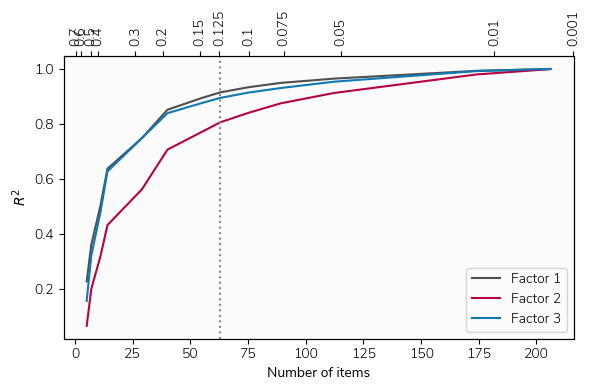

In [8]:
f, ax = plt.subplots(dpi=100, facecolor='white')
for i in range(3):
    ax.plot(n_items, r2_values[i, :], label='Factor {0}'.format(i+1), color=pal[i])
ax.set_xlabel("Number of items")
ax.set_ylabel("$R^2$")
ax.legend()
ax2 = ax.twiny()
ax2.set_xticklabels(alpha_values)
ax2.set_xticks(n_items)
ax.axvline(63, color='#8c8a8a', linestyle=':')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()

plt.savefig('../figures/number_of_questions.svg')

An alpha value of 0.125 looks like it gives a good balance between accurate predictions and a good number of questions.

## Predict factor scores

Using the best hyperparameter values and 5-fold CV.

In [9]:
clf = Lasso(alpha=0.125)
pred = cross_val_predict(clf, qns.iloc[:, 2:], scores.iloc[:, 2:], cv=5)
clf.fit(qns.iloc[:, 2:], scores.iloc[:, 2:]);

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


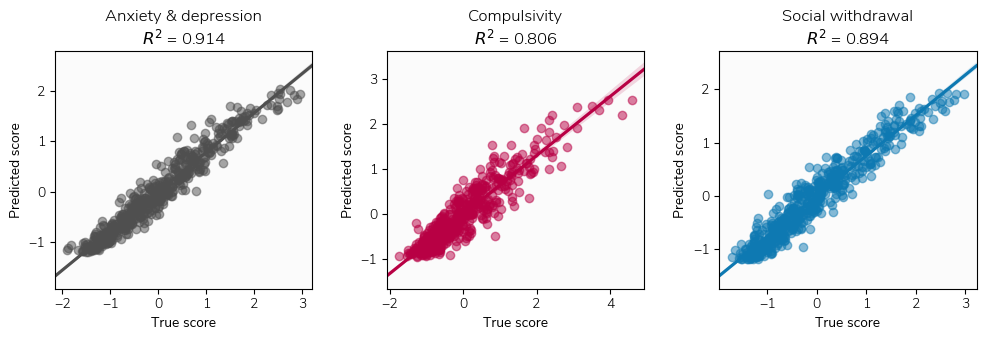

In [10]:
f, ax = plt.subplots(1, 3, figsize=(10, 3.5), dpi=100, facecolor='white')

factors = ['Anxiety & depression', 'Compulsivity', 'Social withdrawal']

for i in range(3):
    sns.regplot(scores.iloc[:, i+2], pred[:, i], ax=ax[i], color=pal[i], scatter_kws={'alpha': 0.5})
    ax[i].set_title(factors[i] + '\n$R^2$ = {0}'.format(np.round(r2_score(scores.iloc[:, i+2], pred[:, i]), 3)), fontweight='light')
    ax[i].set_xlabel('True score')
    ax[i].set_ylabel('Predicted score')
    
plt.tight_layout()
plt.savefig('../figures/factor_prediction.svg')

This seems to do a decent job of predicting true factor scores - the lowest $R^2$ is for compulsivity but is still high at 0.806

## View coefficients

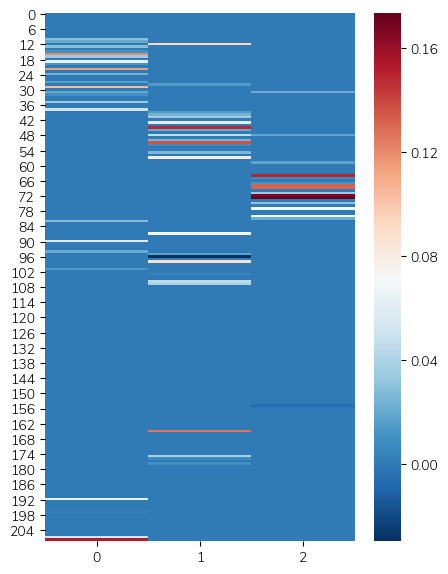

In [11]:
plt.figure(dpi=100, figsize=(5, 7), facecolor='white')
sns.heatmap(clf.coef_.T, cmap='RdBu_r');

As expected, the majority of coefficients are zero. We can look at how many non-zero coefficients we have to see how many questions we retain.

In [12]:
np.any(clf.coef_.T != 0, axis=1).sum()

63

63 questions - which is a lot better than 233!

## Plot coefficients of items with non-zero weighting

This allows us to see which questions we're retaining.

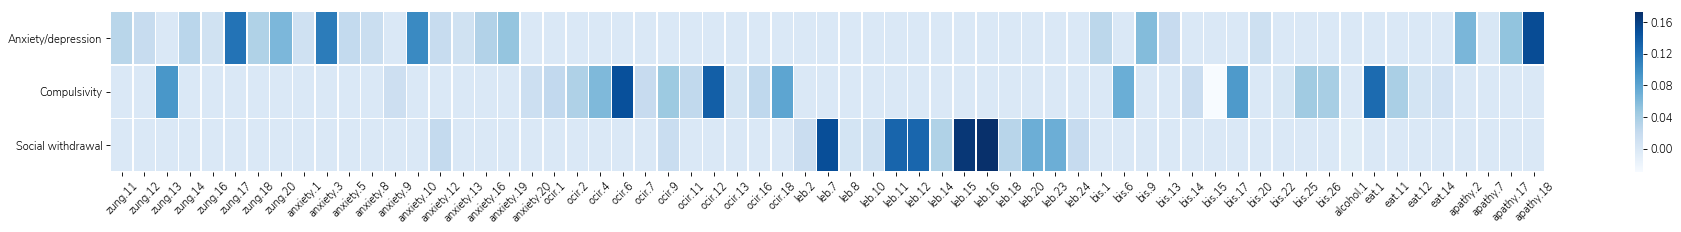

In [13]:
plt.figure(figsize=(24, 3), dpi=80, facecolor='white')
coefs = clf.coef_.T
sns.heatmap(coefs[np.any(coefs != 0, axis=1)].T, cmap="Blues", xticklabels=qns.columns[2:][np.any(coefs != 0, axis=1)],
           yticklabels=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], linewidths=.5);
plt.xticks(rotation=45);
plt.tight_layout()
plt.savefig('../figures/retained_questions.svg')

## Save the classifier

In [14]:
joblib.dump(clf, 'three_factor_classifier.pkl') 

['three_factor_classifier.pkl']

# Analyse questionnaire data

We can now load in our new questionnaire data and use our trained classifier to predict factor scores.

## Load in data

In [5]:
qdata_dir = '../Data'
qdata_files = [i for i in os.listdir(qdata_dir) if 'questionnaire' in i]
print "Number of subjects = {0}".format(len(qdata_files))

Number of subjects = 420


Work out maximum scores for each questionniare - this is used for reverse coded items.

In [6]:
q_info = pd.read_csv('../questionnaires/questionnaires_info.csv')

max_scores = {}

for q in q_info['Measure'].unique():
    max_scores[q] = len(q_info.loc[q_info['Measure'] == q, 'Options'].iloc[0].split(','))

### Convert data to a format that the classifier will accept

Currently our data is in long format but we need it in wide format as this is what the classifier was trained on, with the questions in the expected order. Additionally, we need to recode reverse coded items.

In [8]:
# Empty dataframe to fill in
wide = qns.iloc[:1, 1:].copy()
wide.iloc[:, :] = 0

dfs = []
wide_dfs = []
raw_dfs = []

count = 0

for sub in tqdm(qdata_files):
    break
    df = pd.read_csv(os.path.join(qdata_dir, sub))
    df.columns = [c.replace(' ', '') for c in df.columns]
    df = df[df['value'] != ' undefined'].reset_index()
    df['value'] = df['value'].astype(int) + 1
    df['reverse_coded'] = pd.to_numeric(df['reverse_coded'], errors='coerce')
    df['questionnaire_name'] = df['question_name'].str.extract('([A-Za-z_12]+(?=_))')
    df.loc[df['reverse_coded'].isnull(), 'question_id'] = df.loc[df['reverse_coded'].isnull(), 'question_name']
    df.loc[df['reverse_coded'].isnull(), 'questionnaire_name'] = ''
    # Reverse coding
    for qn in df['questionnaire_name'].unique():
        if len(qn):
            df.loc[(df['questionnaire_name'] == qn) & (df['reverse_coded'] == 1), 'value'] = max_scores[qn] + 1 - \
            df.loc[(df['questionnaire_name'] == qn) & (df['reverse_coded'] == 1), 'value']
    for n, q in enumerate(df['question_id']):
        if q.replace(' ', '') in wide.columns:
            wide.loc[0, q.replace(' ', '')] = df.loc[n, 'value']
    wide.loc[0, 'qnid'] = df.subjectID[0]
    wide_dfs.append(wide.copy())
    
    # Calculate totals for STICSA and IUS
    sticsa_t_sum = df.loc[df.question_name.str.contains('STICSA_T')].value.sum()
    sticsa_s_sum = df.loc[df.question_name.str.contains('STICSA_S')].value.sum()
    ius_sum = df.loc[df.question_name.str.contains('IUS')].value.sum()
    
    dfs.append(pd.DataFrame(dict(Subject=df.subjectID[0], 
                                 STICSA_T=sticsa_t_sum, STICSA_S=sticsa_s_sum, IUS=ius_sum,
                                 asteroid_rating=df.loc[df.question_name.str.contains('asteroid')].value.values,
                                 anxiety=df.loc[df.question_name.str.contains('anxiety')].value.values,
                                 age=df.loc[df.question_name.str.contains('age')].value.values,
                                 sex=df.loc[df.question_name.str.contains('Sex')].value.values)))

    df['question_id'] = df['question_id'].str.replace(' ', '')
    df_p = df.pivot(index='subjectID', columns='question_id', values='value').reset_index()
    raw_dfs.append(df_p)

qns_new = pd.concat(wide_dfs)
dfs = pd.concat(dfs)
raw_dfs = pd.concat(raw_dfs)

  0%|                                                                                          | 0/420 [00:00<?, ?it/s]


NameError: name 'wide_dfs' is not defined

In [107]:
dfs.head()

,IUS,STICSA_S,STICSA_T,Subject,age,anxiety,asteroid_rating,sex
0,33,39,30,54f74bc3fdf99b46ee467b27,27,1,65,1
0,50,29,41,550c3ed5fdf99b3039d68894,32,19,92,2
0,40,32,47,556db04dfdf99b26054b1768,27,23,90,2
0,32,37,27,55747e4afdf99b6752df4183,40,91,101,2
0,34,56,50,557c0bd8fdf99b120dc45dde,39,16,62,2


In [108]:
qns_new.head()

,qnid,zung.1,zung.2,zung.3,zung.4,zung.5,zung.6,zung.7,zung.8,zung.9,...,apathy.9,apathy.10,apathy.11,apathy.12,apathy.13,apathy.14,apathy.15,apathy.16,apathy.17,apathy.18
0,54f74bc3fdf99b46ee467b27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
0,550c3ed5fdf99b3039d68894,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
0,556db04dfdf99b26054b1768,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
0,55747e4afdf99b6752df4183,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,3
0,557c0bd8fdf99b120dc45dde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3


### Predict factor scores

We now use our classifier on this data to generate predicted factor scores for each subject.

In [109]:
factor_score_pred = clf.predict(qns_new.iloc[:, 1:])
factor_score_pred = pd.DataFrame(factor_score_pred, columns=['AD', 'Compul', 'SW'])
factor_score_pred.loc[:, 'Subject'] = qns_new['qnid'].values
factor_score_pred.head()

,AD,Compul,SW,Subject
0,0.099486,1.167769,-0.479319,54f74bc3fdf99b46ee467b27
1,1.241674,1.631405,0.028278,550c3ed5fdf99b3039d68894
2,0.277397,1.775103,-0.011331,556db04dfdf99b26054b1768
3,0.794239,1.698839,-0.057416,55747e4afdf99b6752df4183
4,0.812685,1.718543,-0.004774,557c0bd8fdf99b120dc45dde


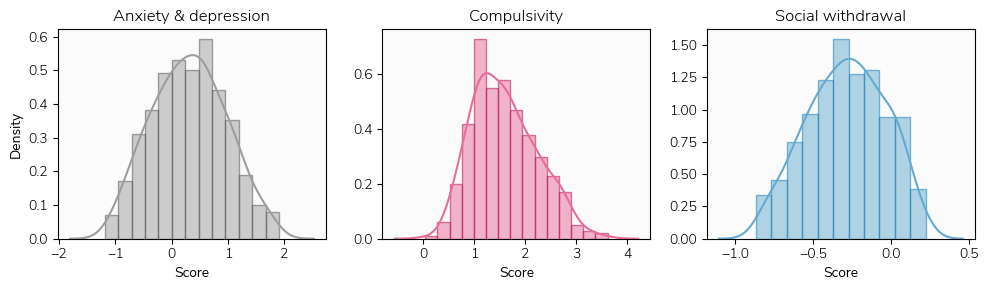

In [110]:
light_pal =['#9e9e9e', '#e86d9a', '#64abd1']

f, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=100, facecolor='white')

for n, factor in enumerate(['AD', 'Compul', 'SW']):
    sns.distplot(factor_score_pred[factor], ax=ax[n], color=light_pal[n], hist_kws={'ec':pal[n], 'alpha':0.5})
    ax[n].set_xlabel('Score')
    if n == 0:
        ax[n].set_ylabel('Density')
    ax[n].set_title(factors[n], fontweight='light')
    
plt.tight_layout()
plt.savefig('../figures/factor_distributions.svg')

## Add other questionnaire measures

In [111]:
full_df = pd.merge(factor_score_pred, dfs, on='Subject')
full_df.to_csv('../Data/qns_full.csv')
full_df.head()

,AD,Compul,SW,Subject,IUS,STICSA_S,STICSA_T,age,anxiety,asteroid_rating,sex
0,0.099486,1.167769,-0.479319,54f74bc3fdf99b46ee467b27,33,39,30,27,1,65,1
1,1.241674,1.631405,0.028278,550c3ed5fdf99b3039d68894,50,29,41,32,19,92,2
2,0.277397,1.775103,-0.011331,556db04dfdf99b26054b1768,40,32,47,27,23,90,2
3,0.794239,1.698839,-0.057416,55747e4afdf99b6752df4183,32,37,27,40,91,101,2
4,0.812685,1.718543,-0.004774,557c0bd8fdf99b120dc45dde,34,56,50,39,16,62,2


In [112]:
reduced_qns = qns.iloc[:, np.any(clf.coef_.T != 0, axis=1)]
reduced_qns.to_csv('reduced_qns.csv')

In [120]:
raw_dfs = raw_dfs.rename(columns={'subjectID': 'Subject'})
raw_dfs.to_csv('raw_qns.csv')

question_id,Subject,Sex_0,age,alcohol.1,anxiety.1,anxiety.10,anxiety.12,anxiety.13,anxiety.16,anxiety.19,...,sticsa_t.8,sticsa_t.9,zung.11,zung.12,zung.13,zung.14,zung.16,zung.17,zung.18,zung.20
0,54f74bc3fdf99b46ee467b27,1,27,4,2,1,3,2,2,2,...,1,1,3,3,3,2,3,2,3,2
0,550c3ed5fdf99b3039d68894,2,32,2,3,3,4,3,3,3,...,1,2,3,3,3,4,4,3,4,3
0,556db04dfdf99b26054b1768,2,27,2,3,2,3,3,4,3,...,1,3,4,3,1,2,3,2,3,3
0,55747e4afdf99b6752df4183,2,40,3,3,2,2,2,3,3,...,1,2,3,3,4,1,4,3,3,2
0,557c0bd8fdf99b120dc45dde,2,39,4,3,3,2,4,3,3,...,2,3,4,2,3,3,3,3,3,3
0,559744acfdf99b590e1e9299,2,34,4,1,1,2,2,2,1,...,1,1,1,1,1,2,2,2,2,1
0,55a2fa33fdf99b073cd94947,2,40,2,2,2,2,2,2,2,...,1,2,2,1,1,2,3,1,2,1
0,55b8113efdf99b4633359b7b,1,30,4,3,3,3,3,2,2,...,2,1,1,2,2,3,2,4,3,3
0,55c4fc3dfdf99b559867a416,2,27,5,3,3,1,2,3,3,...,2,2,2,2,2,3,3,2,3,3
0,5601bbdae372c00011bd3b71,1,37,1,2,1,2,2,2,2,...,1,1,2,1,1,1,2,1,1,2
